# Made by Bohdan Bilokon, FB-11mp

dataset: [SMS Spam Collection v.1](https://www.dt.fee.unicamp.br/~tiago/smsspamcollection/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import string

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

%matplotlib inline

In [2]:
df = pd.read_csv("emails.csv", index_col = False)
df.drop(columns='Email No.', inplace=True)
df.head()

the  to  ect  and  for  of    a  you  hou  in  ...  connevey  jay  valued  \
0    0   0    1    0    0   0    2    0    0   0  ...         0    0       0   
1    8  13   24    6    6   2  102    1   27  18  ...         0    0       0   
2    0   0    1    0    0   0    8    0    0   4  ...         0    0       0   
3    0   5   22    0    5   1   51    2   10   1  ...         0    0       0   
4    7   6   17    1    5   2   57    0    9   3  ...         0    0       0   

   lay  infrastructure  military  allowing  ff  dry  Prediction  
0    0               0         0         0   0    0           0  
1    0               0         0         0   1    0           0  
2    0               0         0         0   0    0           0  
3    0               0         0         0   0    0           0  
4    0               0         0         0   1    0           0  

[5 rows x 3001 columns]

In [3]:
df.shape

(5172, 3001)

In [4]:
df.fillna(0)

the  to  ect  and  for  of    a  you  hou  in  ...  connevey  jay  \
0       0   0    1    0    0   0    2    0    0   0  ...         0    0   
1       8  13   24    6    6   2  102    1   27  18  ...         0    0   
2       0   0    1    0    0   0    8    0    0   4  ...         0    0   
3       0   5   22    0    5   1   51    2   10   1  ...         0    0   
4       7   6   17    1    5   2   57    0    9   3  ...         0    0   
...   ...  ..  ...  ...  ...  ..  ...  ...  ...  ..  ...       ...  ...   
5167    2   2    2    3    0   0   32    0    0   5  ...         0    0   
5168   35  27   11    2    6   5  151    4    3  23  ...         0    0   
5169    0   0    1    1    0   0   11    0    0   1  ...         0    0   
5170    2   7    1    0    2   1   28    2    0   8  ...         0    0   
5171   22  24    5    1    6   5  148    8    2  23  ...         0    0   

      valued  lay  infrastructure  military  allowing  ff  dry  Prediction  
0          0    0               0         0         0   0    0           0  
1          0    0               0         0         0   1    0           0  
2          0    0               0         0         0   0    0           0  
3          0    0               0         0         0   0    0           0  
4          0    0               0         0         0   1    0           0  
...      ...  ...             ...       ...       ...  ..  ...         ...  
5167       0    0               0         0         0   0    0           0  
5168       0    0               0         0         0   1    0           0  
5169       0    0               0         0         0   0    0           1  
5170       0    0               0         0         0   1    0           1  
5171       0    0               0         0         0   0    0           0  

[5172 rows x 3001 columns]

In [5]:
df_1 = df.iloc[:,:-1]
scaler = StandardScaler()
scaler.fit(df_1)
df_1 = pd.DataFrame(scaler.transform(df_1), columns=df_1.columns[:])

# PCA

In [6]:
pca = PCA(n_components=2)
pca_outcome = pca.fit_transform(df_1)

In [7]:
pca.explained_variance_ratio_

array([0.07181724, 0.02393477])

In [8]:
pca_outcome

array([[-8.06981978, -2.85395303],
       [ 7.8782697 ,  4.97657055],
       [-7.86609432, -2.73109773],
       ...,
       [-6.89449668, -3.55578162],
       [-2.94454082, -1.35990346],
       [11.7434366 ,  6.12259265]])

In [9]:
pca_outcome_df = pd.DataFrame(pca_outcome, columns=['PC1', 'PC2'])
pca_outcome_df = pca_outcome_df.join(df.iloc[:,-1])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

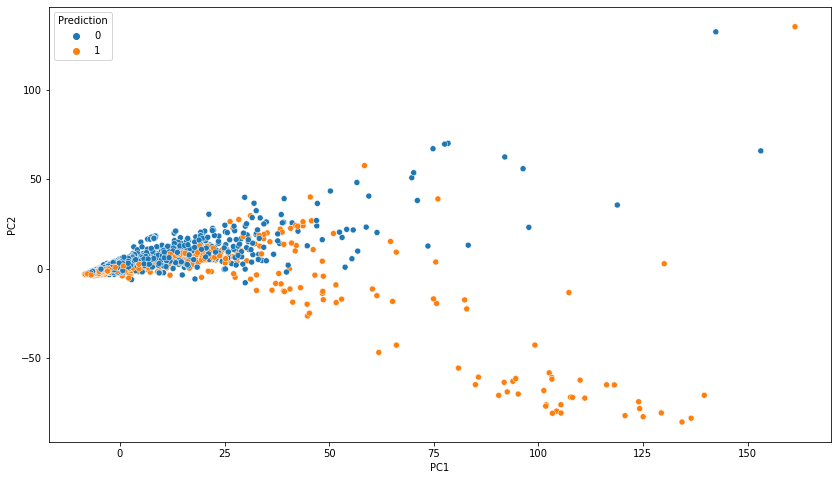

In [10]:
plt.figure(figsize=(14,8))
sns.scatterplot(
    data=pca_outcome_df,
    x='PC1',
    y='PC2',
    hue='Prediction')

# TSNE

In [11]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_outcome = tsne.fit_transform(df_1)

In [12]:
tsne_outcome_df = pd.DataFrame(tsne_outcome, columns=['TSNE1', 'TSNE2'])
tsne_outcome_df = tsne_outcome_df.join(df.iloc[:,-1])

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

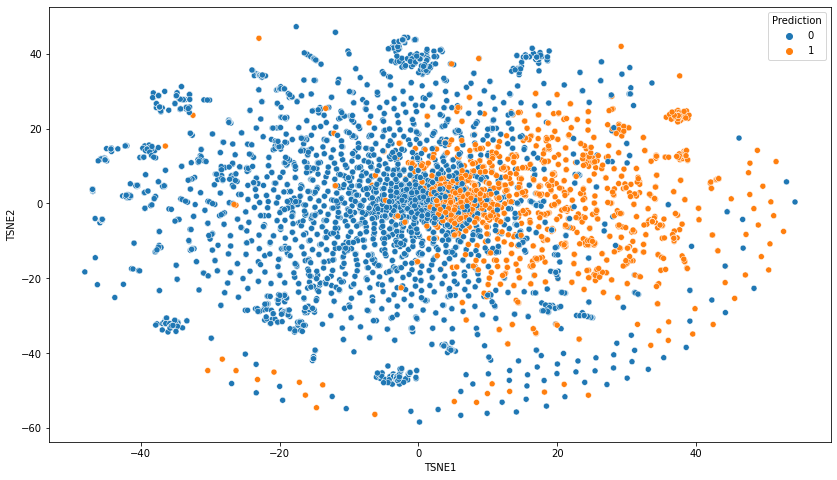

In [13]:
plt.figure(figsize=(14,8))
sns.scatterplot(
    data=tsne_outcome_df,
    x='TSNE1',
    y='TSNE2',
    hue='Prediction')

# Clustering

In [14]:
def convert_rgb_to_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [15]:
dogs = PIL.Image.open('dogs.jpg')
dogs = np.array(dogs, dtype=np.float64) / 255

In [16]:
w, h, d = tuple(dogs.shape)
dogs_array = np.reshape(dogs, (w * h, d))
dogs_subsample = dogs_array[np.random.choice(w * h, int(w * h * 0.01)), :]

In [17]:
colors_num = [8, 16, 32, 64]
models = []
for colors in colors_num:
    kmeans_model = KMeans(n_clusters=colors).fit(dogs_subsample)
    models.append(kmeans_model)

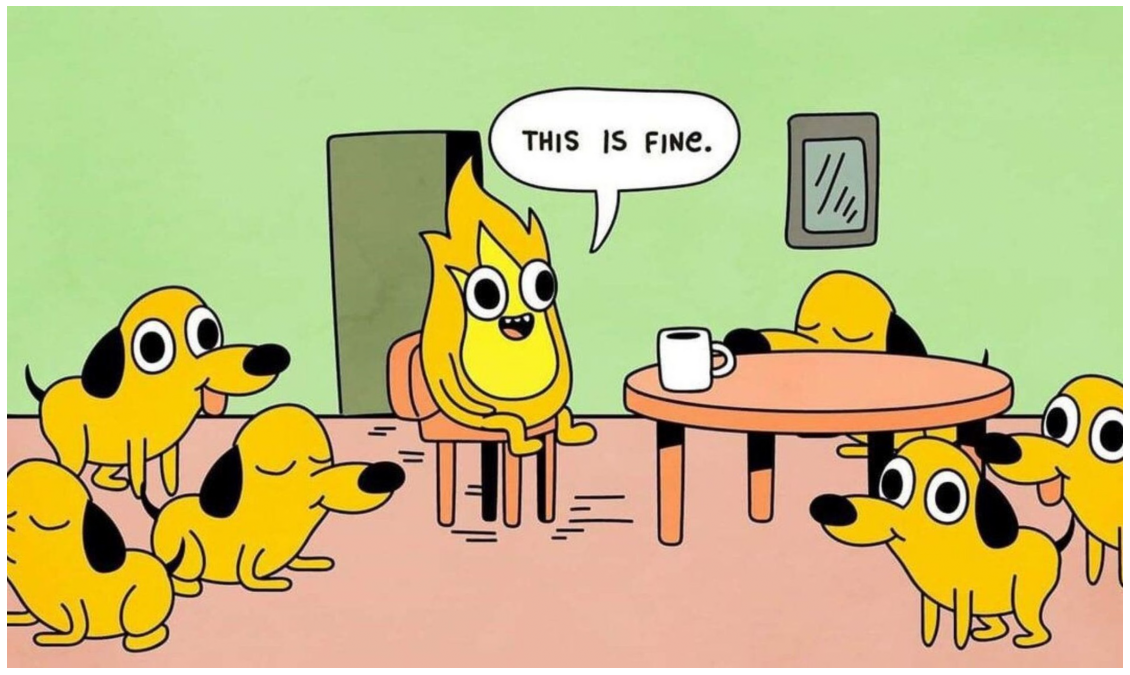

In [18]:
plt.figure(figsize=(20, 15))
plt.axis('off')
plt.imshow(dogs) 

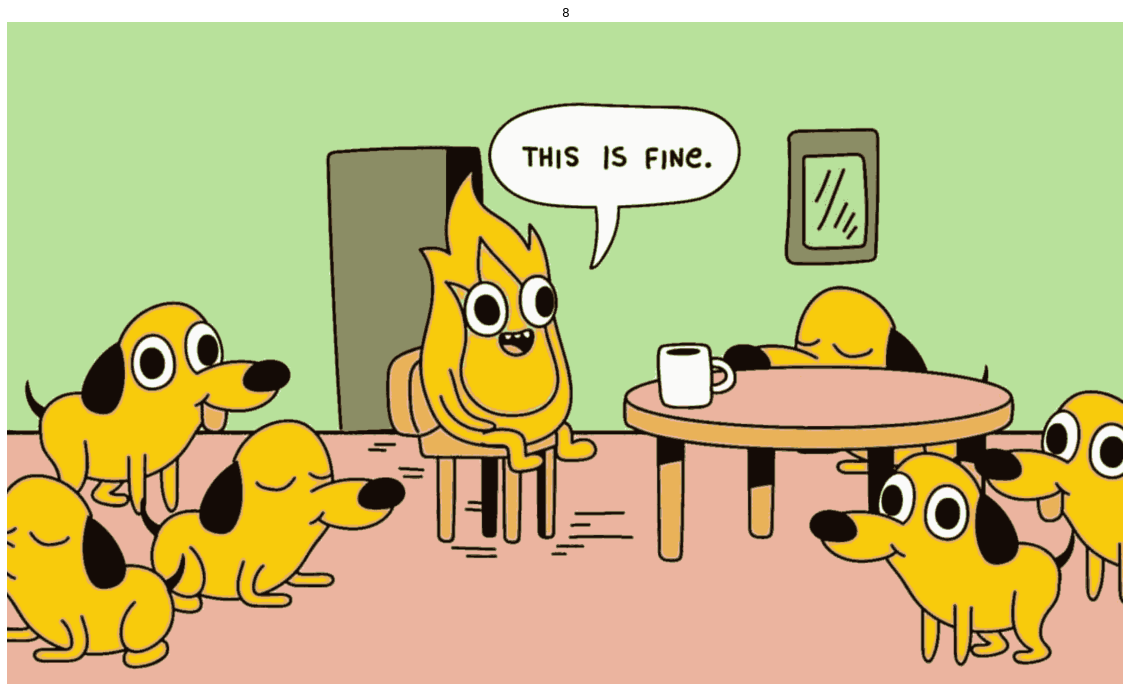

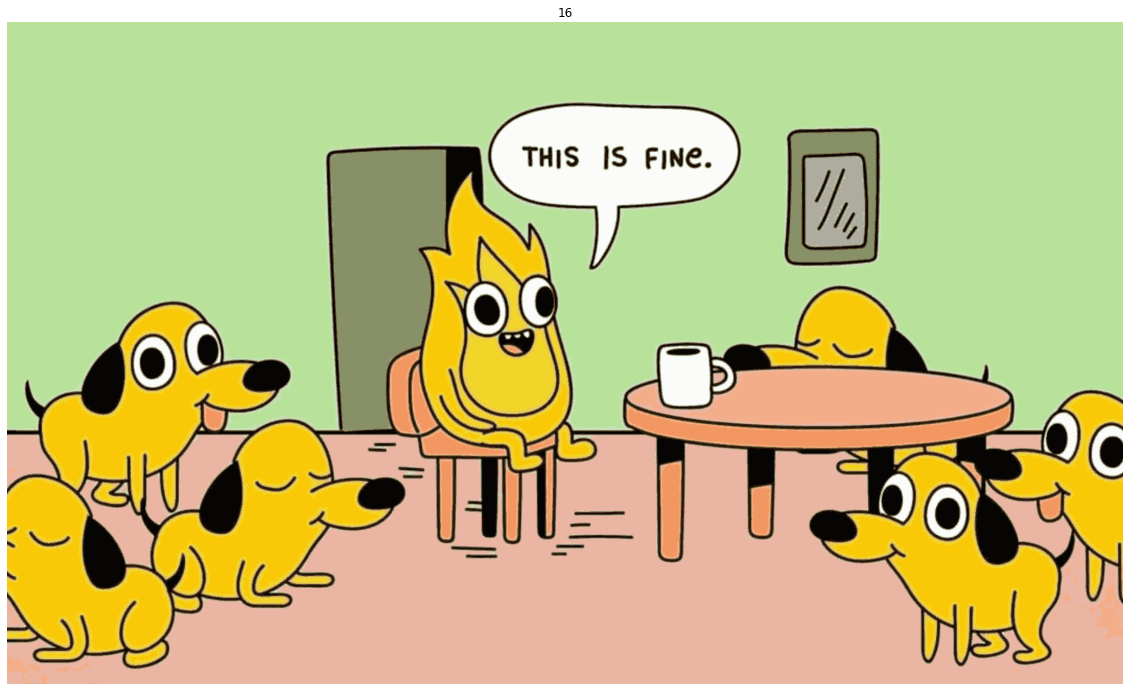

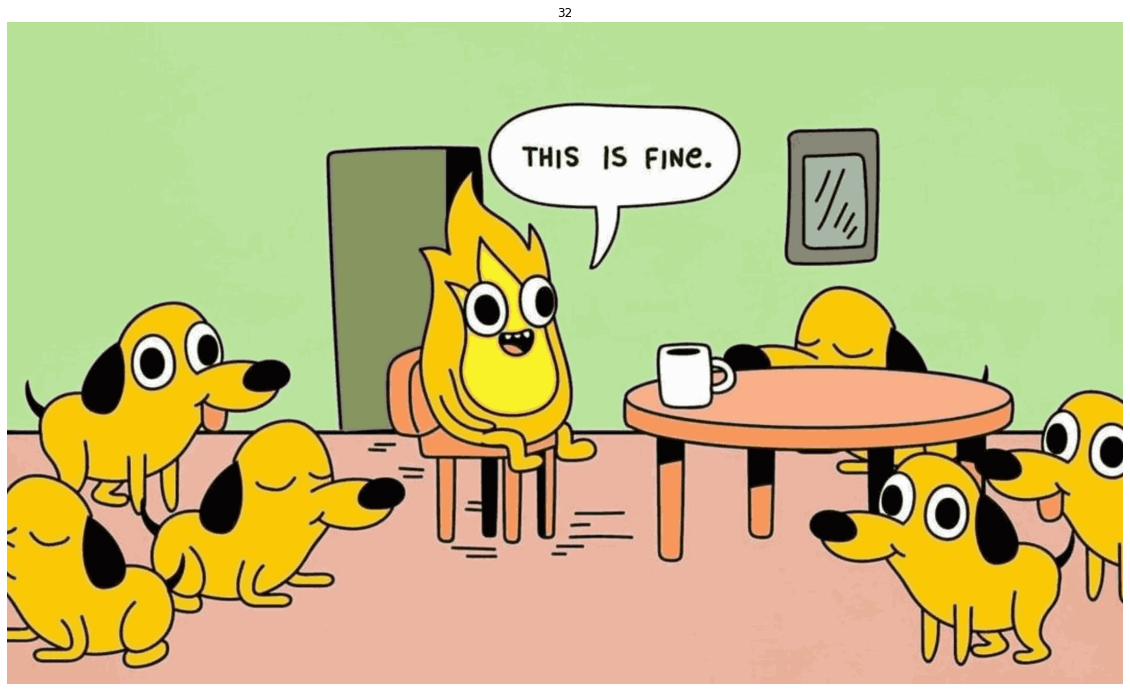

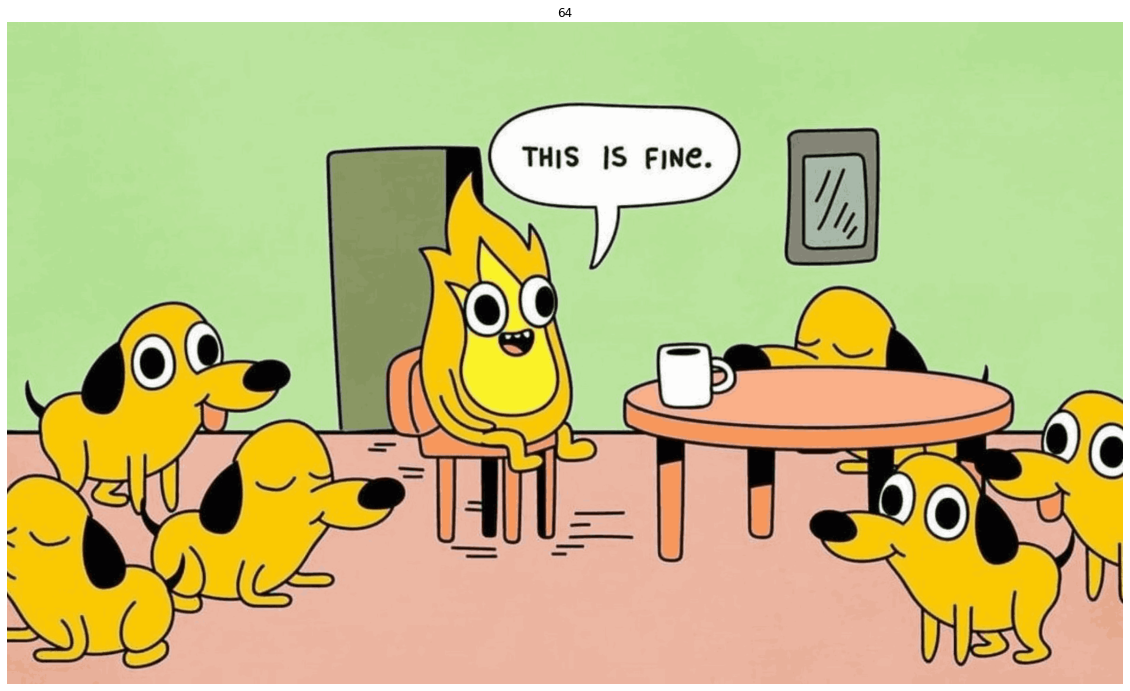

In [19]:
for model in models:
    labels = model.predict(dogs_array)
    plt.figure(figsize=(20,15))
    plt.clf()
    plt.axis('off')
    plt.title(model.get_params().get("n_clusters"))
    plt.imshow(convert_rgb_to_image(model.cluster_centers_, labels, w, h))

# EM

In [20]:
mean = [[0, 0], 
        [4, 4]]
cov = [[[4, 0], 
        [0, 4]], 
       [[2, 0], 
        [0, 2]]]

x = np.random.default_rng().multivariate_normal(mean[0], cov[0], 1000)
y = np.random.default_rng().multivariate_normal(mean[1], cov[1], 1000)
df = np.vstack([x, y])

In [21]:
gm = GaussianMixture(n_components=2, covariance_type='full')
labels = gm.fit_predict(df)

<AxesSubplot:>

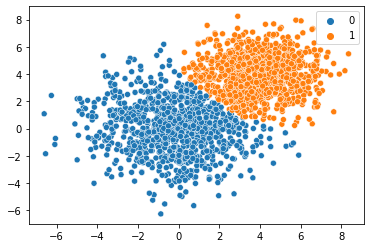

In [22]:
sns.scatterplot(x=df[:,0], y=df[:,1], hue=labels)

In [23]:
gm.covariances_[0]

array([[ 3.97033058, -0.43909492],
       [-0.43909492,  3.69909939]])

In [24]:
x = np.random.default_rng().multivariate_normal(gm.means_[0], gm.covariances_[0], 1000)
y = np.random.default_rng().multivariate_normal(gm.means_[1], gm.covariances_[1], 1000)
df = np.vstack([x,y])

<AxesSubplot:>

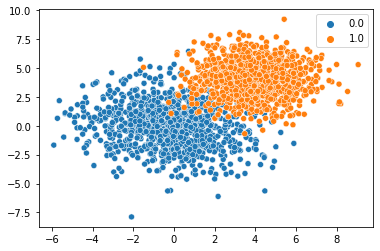

In [25]:
sns.scatterplot(x=df[:,0], y=df[:,1], hue=np.hstack([np.zeros(1000),
                                                     np.ones(1000)]))

# Text data processing

In [26]:
with open('sms.txt', 'r', encoding="utf-8") as f:
    Lines = f.readlines()
c = 0
text = []
for line in Lines:
    help = [0,0]
    if line[:3] == 'ham':
        help[0] = line[4:-1]
        help[0] = help[0].translate(str.maketrans('', '', string.punctuation))
        help[1] = 0
    else:
        help[0] = line[5:-1]
        help[0] = help[0].translate(str.maketrans('', '', string.punctuation))
        help[1] = 1
    text.append(help)
df = pd.DataFrame(text, columns=['sms', 'class'])
df.head()

sms  class
0  Go until jurong point crazy Available only in ...      0
1                            Ok lar Joking wif u oni      0
2  Free entry in 2 a wkly comp to win FA Cup fina...      1
3        U dun say so early hor U c already then say      0
4  Nah I dont think he goes to usf he lives aroun...      0

In [27]:
df['sms'] = df['sms'].str.lower()
df['sms'] = df['sms'].str.strip()
df['sms'] = df['sms'].str.replace('\d+','number', regex=True)
df.head()

sms  class
0  go until jurong point crazy available only in ...      0
1                            ok lar joking wif u oni      0
2  free entry in number a wkly comp to win fa cup...      1
3        u dun say so early hor u c already then say      0
4  nah i dont think he goes to usf he lives aroun...      0

In [28]:
df['sms'] = df['sms'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [29]:
df.head()

sms  class
0  go jurong point crazy available bugis n great ...      0
1                            ok lar joking wif u oni      0
2  free entry number wkly comp win fa cup final t...      1
3                u dun say early hor u c already say      0
4        nah dont think goes usf lives around though      0

# WordCloud

In [36]:
def construct_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

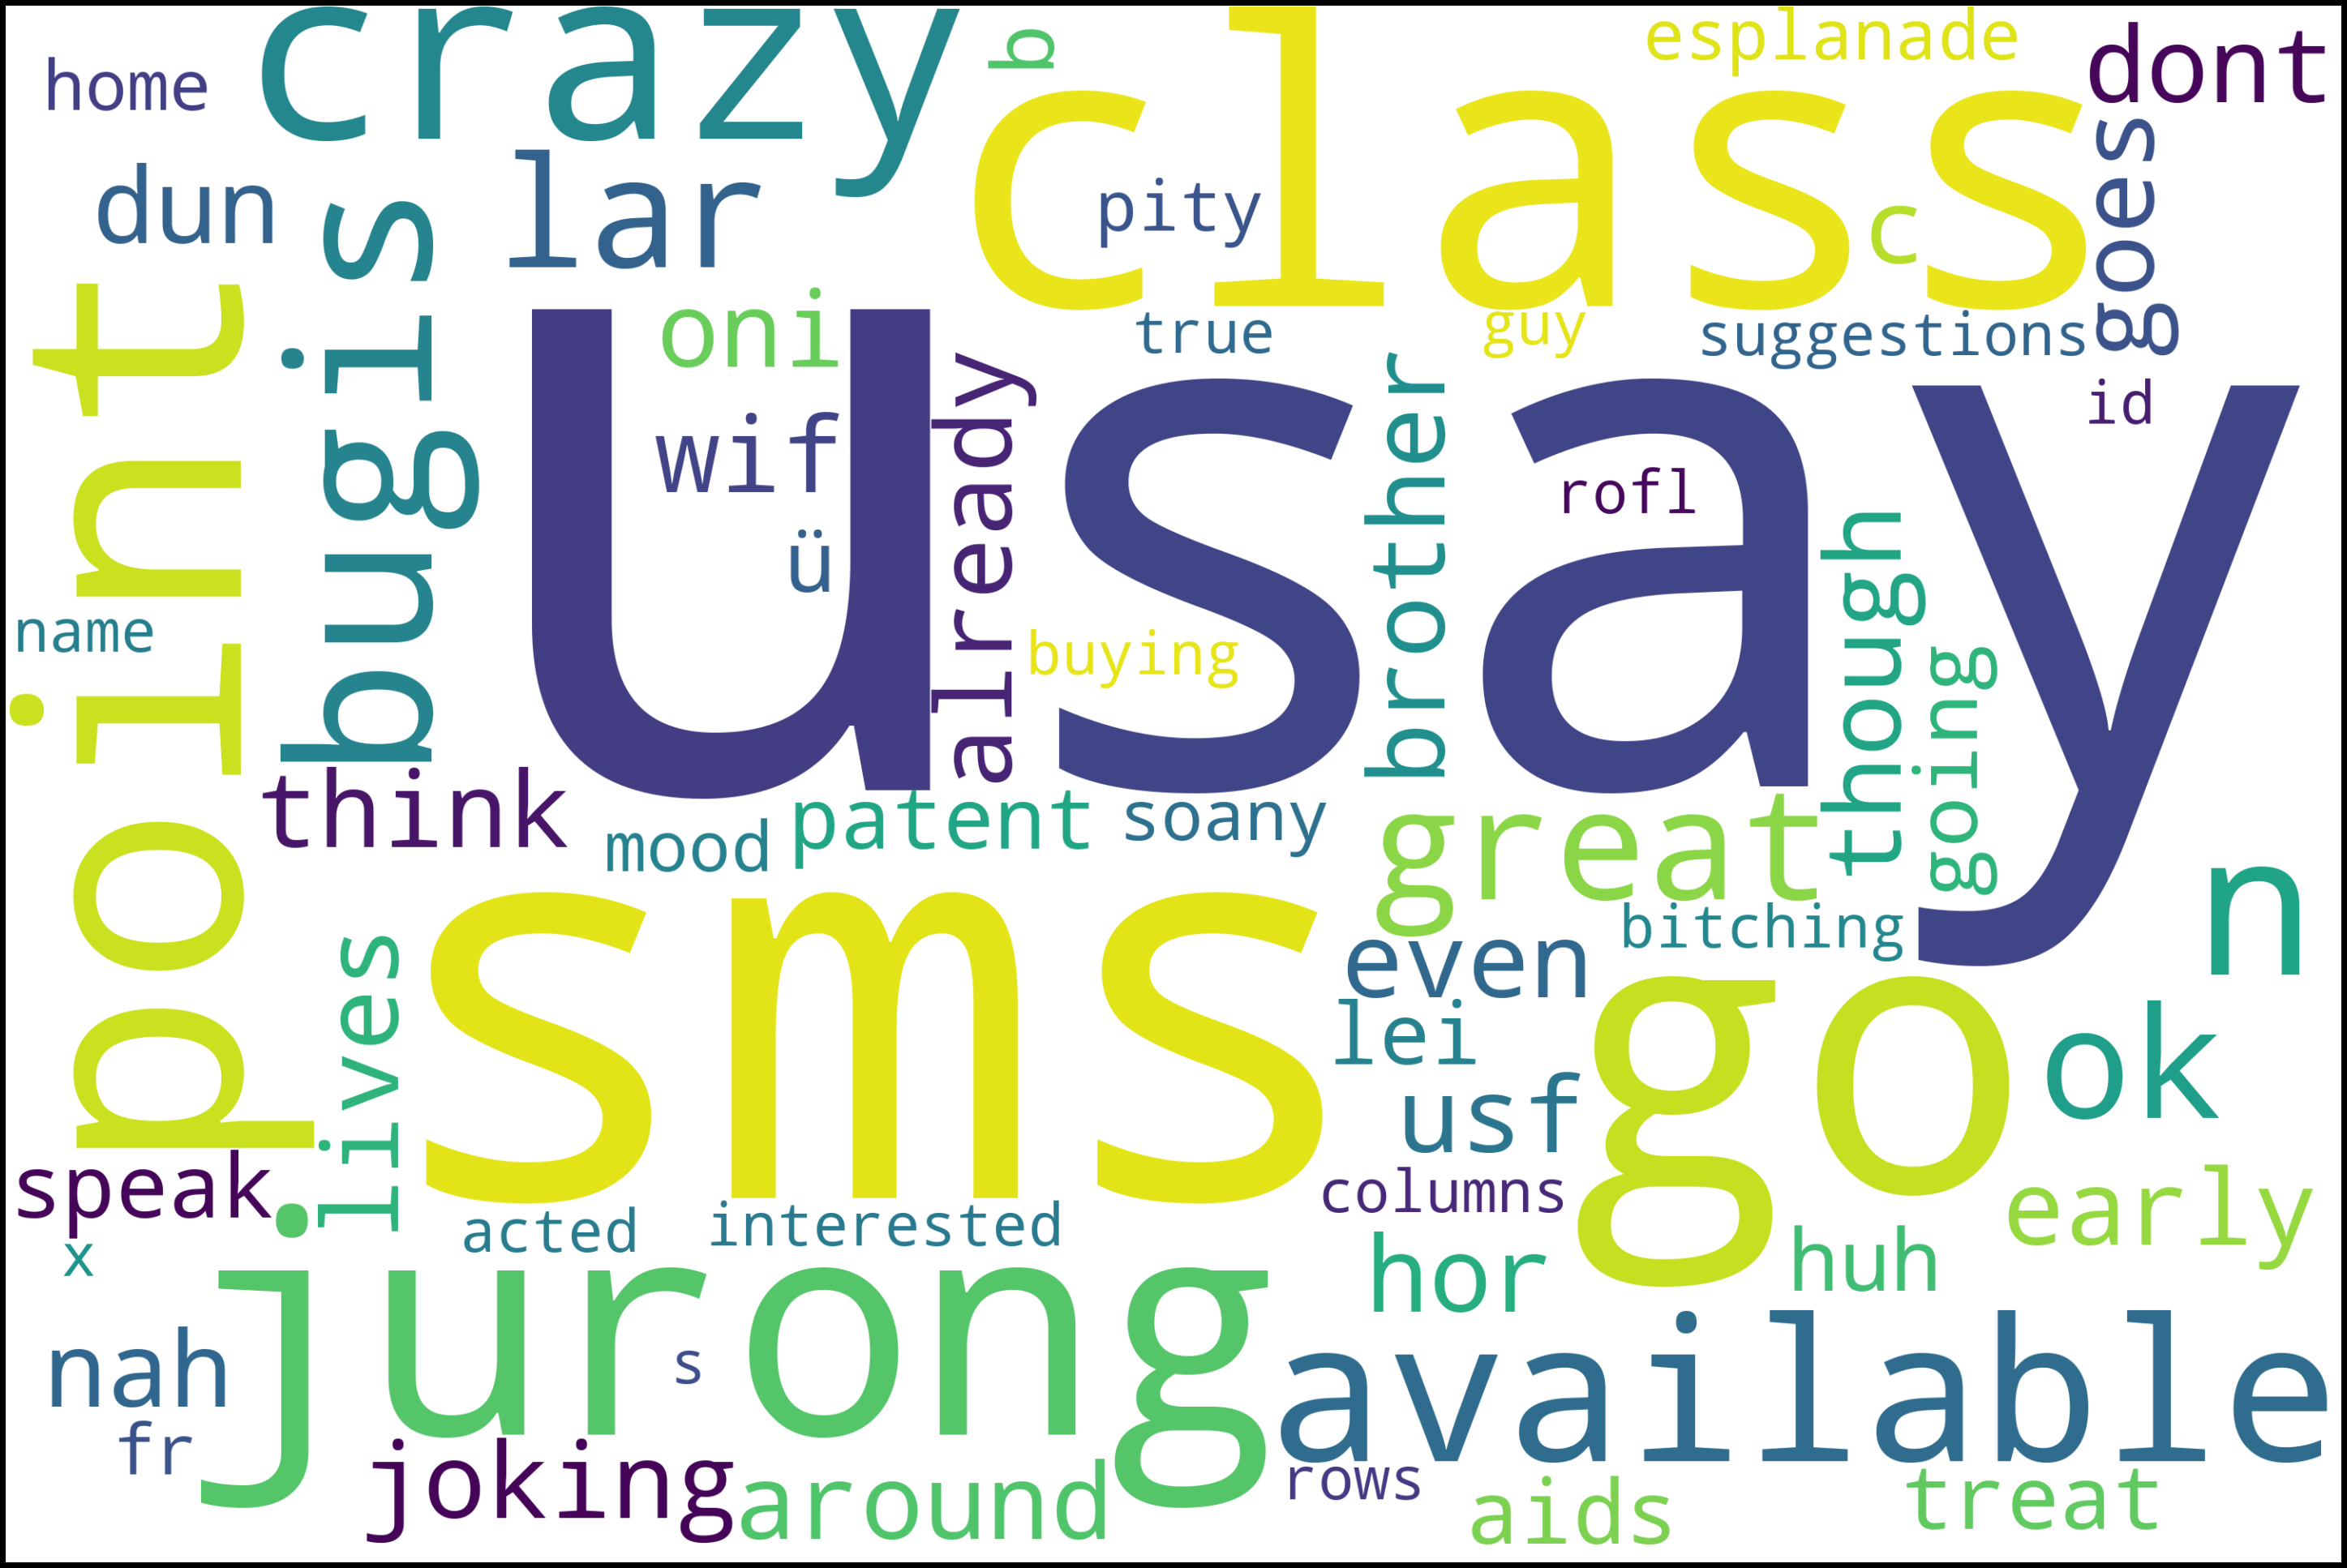

In [37]:
construct_word_cloud(df[df['class']==0])

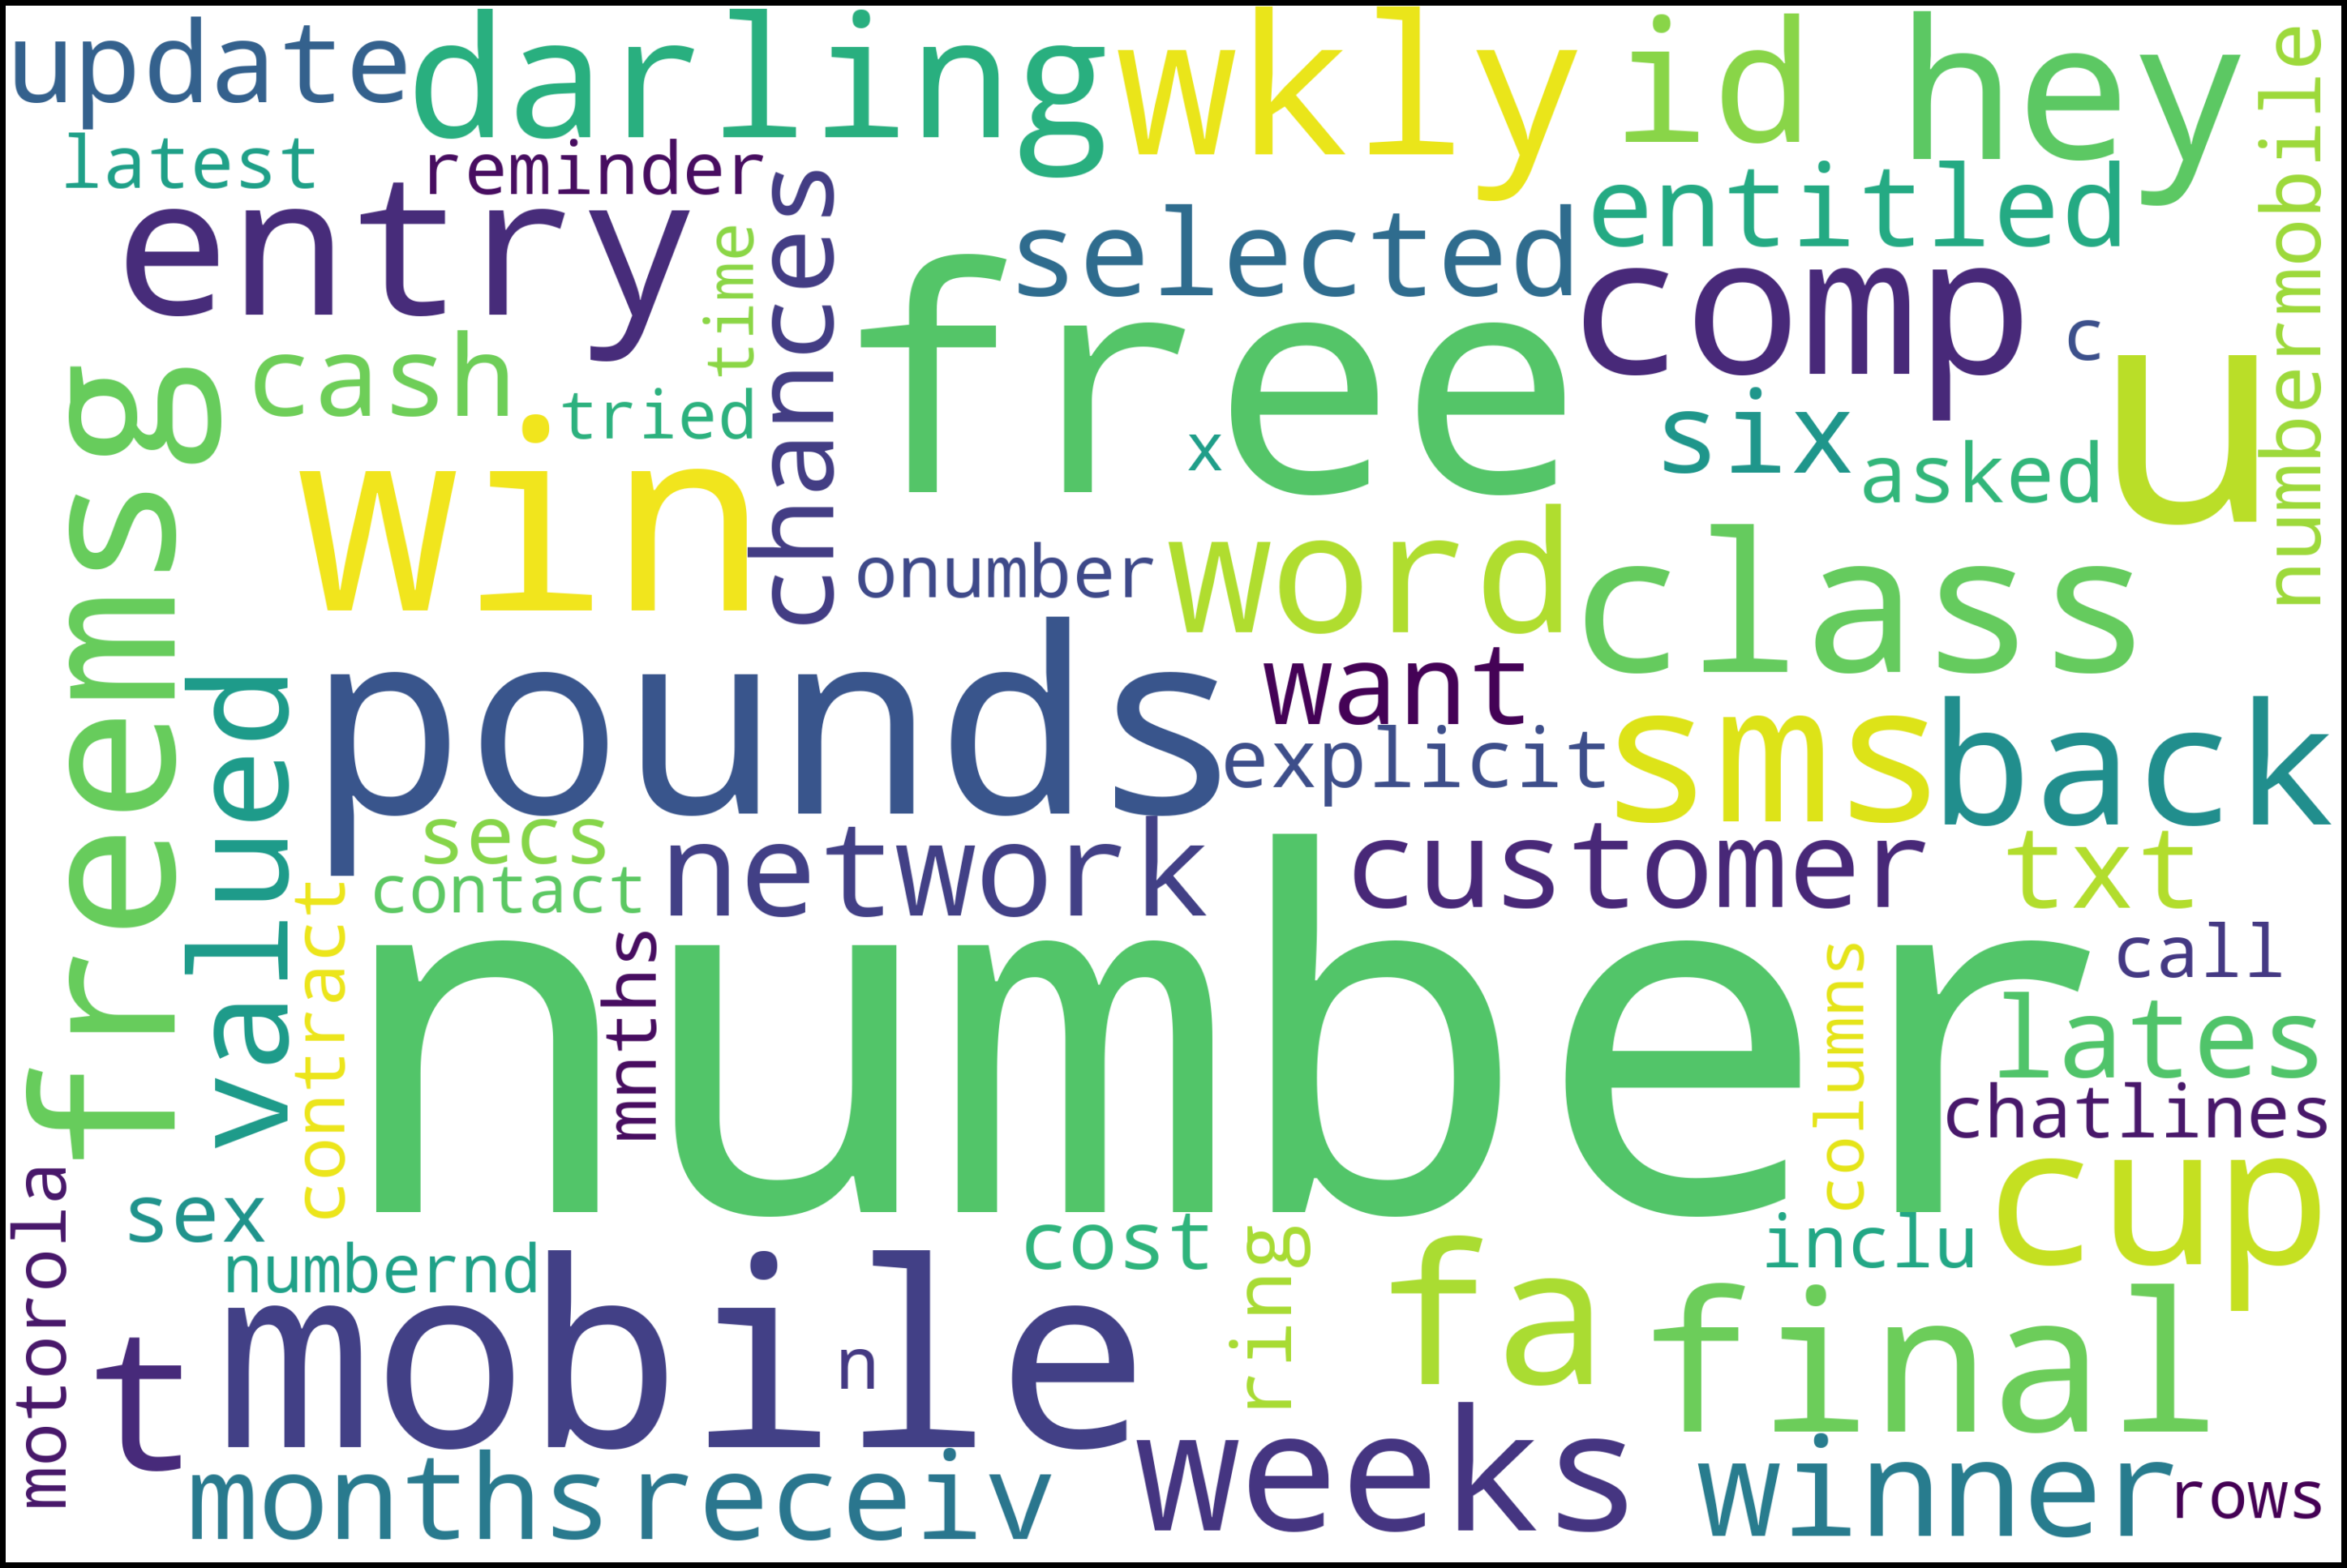

In [38]:
construct_word_cloud(df[df['class']==1])

# Vectorization

In [39]:
x = TfidfVectorizer(max_features=5000).fit_transform(df['sms'])
y = df['class']

In [40]:
print(y)

0       0
1       0
2       1
3       0
4       0
       ..
5569    1
5570    0
5571    0
5572    0
5573    0
Name: class, Length: 5574, dtype: int64


# Classification

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [42]:
svm = SVC().fit(x_train, y_train)
svm_pred = svm.predict(x_test)
print(f'Confusion matrix: \n{confusion_matrix(y_test, svm_pred)}')
print(f'Classification report: \n{classification_report(y_test, svm_pred)}')

Confusion matrix: 
[[950   0]
 [ 22 143]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       950
           1       1.00      0.87      0.93       165

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# LDA

In [43]:
positive = df[df["class"] == 0]

x_positive = TfidfVectorizer(max_features=5000).fit_transform(positive['sms'])

lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(x_positive)
lda.transform(x_positive[-4:])

array([[0.12478774, 0.75555864, 0.11965362],
       [0.12682139, 0.11286744, 0.76031118],
       [0.16823723, 0.48915762, 0.34260514],
       [0.13131801, 0.74204858, 0.12663341]])

In [44]:
negative = df[df["class"] == 1]

x_negative = TfidfVectorizer(max_features=5000).fit_transform(negative['sms'])

lda = LatentDirichletAllocation(n_components=3, random_state=0)
lda.fit(x_negative)
lda.transform(x_negative[-4:])

array([[0.75655209, 0.17673878, 0.06670913],
       [0.24446442, 0.68344126, 0.07209433],
       [0.44018391, 0.10129395, 0.45852214],
       [0.85362806, 0.07210483, 0.07426711]])